# SPEED analysis

First we ASSEMBLE it, after that its been LABELED. Then its PACKAGED and these going into a CARTON. At last the Cartons get PALLETIZED   
It goes from Assembly (Harro Hoefliger) to Labeler (Krones) to Packaging (Schubert Verpacker) to Cartoner (Pester Umverpacker) to Palletizer (Pester)




|IP_TAG Name   |Machine|German|Optimum Speed|Alarm File location|
|--------------|-------|------|-------------|-------------------| 
|36630901_SPEED|Assembly|Montage|32 used but 35|Y:\E00_Solostar\E6_Assembly_Line_6\E63_Montage\CSV|   
|36640901_SPEED|Labeler|Etikettierer|500|Y:\E00_Solostar\E6_Assembly_Line_6\E64_Etikettierer\AuditTrail|   
|36650901_SPEED|Packaging (Pacemaker!)|Kartonierer|450 (3pcs) or 500 (5pcs)|Y:\E00_Solostar\E6_Assembly_Line_6\E65_Kartonierer\40 - Reports|   
|36680901_SPEED|Cartoner|Endverpacker (UVP)|upstream can only produce 500 max, so this max must be 500|Y:\E00_Solostar\E6_Assembly_Line_6\E68_Endverpacker\UVP|   
|36680902_SPEED|Palletizer|PAL|upstream can only produce 500 max, so this max must be 500|Y:\E00_Solostar\E6_Assembly_Line_6\E68_Endverpacker\PAL|       

adjust the IP_TREND_VALUE (speeds) to show multiple assembly lines (16) or pens per packets (3 or 5), or packets per carton (always 40), or cartons per Pallet (always 50)

In [1]:
import configparser

Config = configparser.ConfigParser()

Config.read('settings.cfg')

def ConfigSectionMap(section):
    dict1 = {}
    options = Config.options(section)
    for option in options:
        try:
            dict1[option] = Config.get(section, option)
            if dict1[option] == -1:
                print("skip: %s" % option)
        except:
            print("exception on %s!" % option)
            dict1[option] = None
    return dict1



dir_sanofi_share = ConfigSectionMap("SectionOne")['sanofi']
dir_local = ConfigSectionMap("SectionOne")['local']

print ("dir_sanofi_share is %s" % (dir_sanofi_share))
print ("dir_local is %s" % (dir_local))


dir_sanofi_share is /Users/mark/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD
dir_local is /Users/mark/Documents/McLaren2021/Sanofi/


In [84]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# pdf reporting libs
import matplotlib.backends.backend_pdf

out_pdf = r'speed_analysis_charts.pdf'

mark_pdf = matplotlib.backends.backend_pdf.PdfPages(out_pdf)

In [3]:
# read IP21 SPEED files for AL6 packaging machines
folder = 'IP21_data'
path = os.path.join(dir_sanofi_share, folder)

Files = []
df = []
df_speed = pd.DataFrame()

for filename in os.listdir( path ):
    if filename.endswith('_SPEED.csv'):
        Files.append(filename)

Files.sort(key=str.lower)

# Loop through all the files.
for filename in Files:
    path = os.path.join(dir_sanofi_share, folder, filename)
    # print (filename)
    df = pd.read_csv(path)
    df['Filename'] = filename
    df_speed = df_speed.append(df)




In [4]:
# get the packaging DESIGNATION file which shows the pcs format
folder = 'IP21_data'
path = os.path.join(dir_sanofi_share, folder)

Files = []
df_designation = pd.DataFrame()

for filename in os.listdir( path ):
    if filename.endswith('36650901_DESIGNATION.csv'):      
        path = os.path.join(dir_sanofi_share, folder, filename)
        # print (filename)
        df_designation = pd.read_csv(path)
        df_designation['Filename'] = filename

# just keep the Good QLEVEL and VALUEs like 'FS...'
df_designation = df_designation[(df_designation.IP_TREND_QLEVEL == 'Good') & (df_designation.IP_TREND_VALUE.str.contains('FS'))]


In [5]:
df_designation

,Name,IP_TREND_TIME,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS,Filename
0,36650901_DESIGNATION,18-AUG-21 21:24:56.5,FS 5er Toujeo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
2,36650901_DESIGNATION,18-AUG-21 12:07:27.9,FS 5er Toujeo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
4,36650901_DESIGNATION,18-AUG-21 11:56:23.4,FS 5er Solo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
8,36650901_DESIGNATION,16-AUG-21 06:55:09.3,FS 5er Solo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
10,36650901_DESIGNATION,12-AUG-21 16:54:58.9,FS 5er Solo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
14,36650901_DESIGNATION,06-AUG-21 18:57:04.4,FS 3er Toujeo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
16,36650901_DESIGNATION,06-AUG-21 11:44:07.5,FS 3er Toujeo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
18,36650901_DESIGNATION,06-AUG-21 11:21:30.1,FS 3er Toujeo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
20,36650901_DESIGNATION,05-AUG-21 03:52:42.8,FS 3er Toujeo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
22,36650901_DESIGNATION,05-AUG-21 03:41:18.2,FS 3er Toujeo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv


Tags for Machine speeds:

|IP_TAG Name   |Machine|Optimum Speed|
|--------------|-------|------------|
|36630901_SPEED|Assembly|32 steps x16 lines (= 512) used but max could be 35 steps|   
|36640901_SPEED|Labeler|500 pcs / min|   
|36650901_SPEED|Packaging (Pacemaker!)|3pcs per package x 150 steps = 450/min, or 5pcs per package x 100 steps = 500/min|   
|36680901_SPEED|Cartoner|aka UVP - 500 max derived from upstream|   
|36680902_SPEED|Palletizer|aka PAL - 500 max derived from upstream|    

In [6]:
# convert dates to datetime format
df_speed['IP_TREND_TIME'] = pd.to_datetime(df_speed['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_designation['IP_TREND_TIME'] = pd.to_datetime(df_designation['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_designation = df_designation.sort_values('IP_TREND_TIME')
# df_speed.set_index('IP_TREND_TIME', inplace=True)

In [7]:
# df_designation.info()
df_speed = pd.merge_asof(df_speed.sort_values('IP_TREND_TIME'), df_designation[['IP_TREND_TIME','IP_TREND_VALUE']].sort_values('IP_TREND_TIME'),on='IP_TREND_TIME', allow_exact_matches=True)
# rename IP_TREND_VALUE_y Format to avoid confusion
df_speed.rename(columns={'IP_TREND_VALUE_y':'Format',
                         'IP_TREND_VALUE_x':'IP_TREND_VALUE'}, inplace=True)

In [8]:
df_speed.head()

,Name,IP_TREND_TIME,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS,Filename,Format
0,36650901_SPEED,2021-08-01 00:07:42.800,0,Good,Good,tabIP21Data_36650901_SPEED.csv,NaN
1,36630901_SPEED,2021-08-01 00:08:10.500,0,Good,Good,tabIP21Data_36630901_SPEED.csv,NaN
2,36640901_SPEED,2021-08-01 00:08:16.700,0,Good,Good,tabIP21Data_36640901_SPEED.csv,NaN
3,36680901_SPEED,2021-08-01 00:08:42.400,0,Good,Good,tabIP21Data_36680901_SPEED.csv,NaN
4,36680902_SPEED,2021-08-01 00:09:14.200,0,Good,Good,tabIP21Data_36680902_SPEED.csv,NaN


In [9]:
# label the rows with the Machine name
df_speed['Machine'] = ''
df_speed.loc[df_speed['Name'] == '36630901_SPEED', 'Machine'] = 'Assembly'
df_speed.loc[df_speed['Name'] == '36640901_SPEED', 'Machine'] = 'Labeler'
df_speed.loc[df_speed['Name'] == '36650901_SPEED', 'Machine'] = 'Packaging'
df_speed.loc[df_speed['Name'] == '36680901_SPEED', 'Machine'] = 'Cartoner'
df_speed.loc[df_speed['Name'] == '36680902_SPEED', 'Machine'] = 'Palletizer'

# set the Max_Speeds
df_speed['Max_Speed'] = ''
df_speed.loc[df_speed['Machine'] == 'Assembly', 'Max_Speed'] = (32*16)
df_speed.loc[df_speed['Machine'] == 'Labeler', 'Max_Speed'] = 500
# set the packaging machine to default 450 Max_Speed
df_speed.loc[df_speed['Machine'] == 'Packaging', 'Max_Speed'] = 450
# dont know what the max speeds of Cartoner and Palletizer are, so derived from upstream max
df_speed.loc[df_speed['Machine'] == 'Cartoner', 'Max_Speed'] = 450
df_speed.loc[df_speed['Machine'] == 'Palletizer', 'Max_Speed'] = 450
df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Packaging'), 'Max_Speed'] = df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Packaging'), 'Max_Speed'] = 500
df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Cartoner'), 'Max_Speed'] = df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Packaging'), 'Max_Speed'] = 500
df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Palletizer'), 'Max_Speed'] = df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Palletizer'), 'Max_Speed'] = 500


# adjust the IP_TREND_VALUE (speeds) to show multiple assembly lines (16) or pens per packets (3 or 5), or packets per carton (always 40), or cartons per Pallet (50)
# assembly value is multipied by 16 (lines)
df_speed.loc[df_speed.Machine == 'Assembly', 'IP_TREND_VALUE'] = df_speed.loc[df_speed.Machine == 'Assembly', 'IP_TREND_VALUE'].mul(16)
# Packaging IP_TREND_VALUE is multiplied by pcs format - we can use the Max_Speed now to work that out
# df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'].mul(5)
# df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'].mul(3)
# df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'].mul(3*40)
# df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'].mul(5*40)
# df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'].mul(3*40)
# df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'].mul(5*40)

# create a new derived_speed col and leave the IP_TREND_VALUE as raw data
df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Packaging'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'].mul(5)
df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Packaging'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'].mul(3)
df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Cartoner'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'].mul(3*40)
df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Cartoner'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'].mul(5*40)
df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Palletizer'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'].mul(3*40)
df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Palletizer'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'].mul(5*40)

# and just copy the IP_TREND_VALUE across for the assembly and labeler as no adjustments made
df_speed.loc[df_speed['Machine'] == 'Assembly', 'Derived_Speed'] = df_speed.loc[df_speed['Machine'] == 'Assembly', 'IP_TREND_VALUE']
df_speed.loc[df_speed['Machine'] == 'Labeler', 'Derived_Speed'] = df_speed.loc[df_speed['Machine'] == 'Labeler', 'IP_TREND_VALUE']

In [10]:
# take dates found in df_speed
start_date = df_speed.IP_TREND_TIME.min()
end_date = df_speed.IP_TREND_TIME.max()

daterange = pd.date_range(start = start_date, end = end_date, freq='S')

df_dates = pd.DataFrame(daterange)
df_dates.rename(columns={0:'datetime'}, inplace=True)
# df_dates.set_index(0, inplace=True)

In [11]:

df_speed2 = pd.merge_asof(df_speed.sort_values('IP_TREND_TIME'), df_dates.sort_values('datetime'), right_on='datetime', left_on='IP_TREND_TIME', tolerance=pd.Timedelta("1s"), direction='backward', allow_exact_matches=True)
df_speed = pd.merge(df_dates, df_speed2, on='datetime', how='left')
df_speed.set_index('datetime', inplace=True)

# CHANGEOVER

In [12]:
# CHANGEOVER
folder = 'IP21_data'

Files = []
df_BATCHACTIVE = pd.DataFrame()
df_CNTR_GOOD = pd.DataFrame()
path = os.path.join(dir_sanofi_share, folder)

for filename in os.listdir( path ):
    # this will only find files for Assembly and Packaging
    if '36680902_BATCHACTIVE' in filename:
        path = os.path.join(dir_sanofi_share, folder, filename)
        df_BATCHACTIVE = pd.read_csv(path)

    if '36680902_CNTR_GOOD' in filename:
        path = os.path.join(dir_sanofi_share, folder, filename)
        df_CNTR_GOOD = pd.read_csv(path)
        
df_CNTR_GOOD = df_CNTR_GOOD.sort_values('IP_TREND_TIME')
df_BATCHACTIVE = df_BATCHACTIVE.sort_values('IP_TREND_TIME')
df_changeover = []
# find where previous row was -1 (active) and this row is 0 (inactive) - this is the start of changeover
df_changeover = df_BATCHACTIVE[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_BATCHACTIVE['IP_TREND_VALUE'].shift(1) == -1) & (df_BATCHACTIVE['IP_TREND_VALUE'] == 0)]

# find where previous row was 0 (batch not started) and this row is >1 (batch running) - changeover has finished
df_changeover = df_changeover.append(df_CNTR_GOOD[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_CNTR_GOOD['IP_TREND_VALUE'].shift(1) == 0) & (df_CNTR_GOOD['IP_TREND_VALUE'] > 0)])
df_changeover.sort_values('IP_TREND_TIME', inplace=True)

# now, in case there are many BATCHACTIVEs for 1 CNTR_GOOD, only get the first BATCHACTIVE 
df_changeover2 = df_changeover[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_changeover['IP_TREND_VALUE'].shift(1) == 1) & (df_changeover['IP_TREND_VALUE'] == 0)]
df_changeover2 = df_changeover2.append(df_changeover[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_changeover['IP_TREND_VALUE'].shift(1) == 0) & (df_changeover['IP_TREND_VALUE'] == 1)])

# add the first row of changeover if it is a BATCHACTIVE, otherwise it gets dropped by above logic
df_changeover2 = df_changeover2.append(df_changeover[:1].loc[df_changeover[:1].Name == '36680902_BATCHACTIVE'])
df_changeover2.sort_values('IP_TREND_TIME', inplace=True)

# convert dates to datetime format
df_changeover2['IP_TREND_TIME'] = pd.to_datetime(df_changeover2['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')

# find the speed and time diff, turn into minutes
df_changeover2['time_diff_mins'] = df_changeover2.IP_TREND_TIME.diff().dt.seconds / 60
df_changeover2['time_diff_mins'].fillna(0, inplace=True)
df_changeover2['time_diff_mins'] = np.array(df_changeover2['time_diff_mins'], dtype=int)
# df_changeover2.set_index('IP_TREND_TIME', inplace=True)

# reshape the changeover dataframe so that we have a start and end time on 1 line - easier for charting later
df_changeover3 = pd.DataFrame({'start':df_changeover2.IP_TREND_TIME.iloc[::2].values, 'end':df_changeover2.IP_TREND_TIME.iloc[1::2].values, 'time_diff_mins':df_changeover2.time_diff_mins.iloc[1::2].values})
for i, row in df_changeover3.iterrows():
    print (i, row[0], row[1])

0 2021-08-02 22:47:04.100000 2021-08-02 23:33:13.200000
1 2021-08-03 19:48:39.600000 2021-08-03 21:08:45.100000
2 2021-08-04 00:56:14.200000 2021-08-04 02:05:46.100000
3 2021-08-04 07:01:24.900000 2021-08-04 07:37:14.500000
4 2021-08-05 20:07:04.200000 2021-08-05 20:50:02
5 2021-08-06 00:30:29.400000 2021-08-06 03:04:38.500000
6 2021-08-06 11:04:49.200000 2021-08-06 12:55:08.100000
7 2021-08-07 01:48:36.400000 2021-08-07 03:10:52.900000
8 2021-08-10 09:33:14.700000 2021-08-10 10:49:15.300000
9 2021-08-12 10:17:53 2021-08-12 11:01:49
10 2021-08-12 16:07:40.400000 2021-08-12 19:32:39.600000
11 2021-08-16 09:27:53.300000 2021-08-16 10:27:43.600000
12 2021-08-18 11:46:40.400000 2021-08-18 12:57:14


In [13]:
# convert max_speed to numeric
df_speed['Max_Speed'] = pd.to_numeric(df_speed['Max_Speed'])



# STATE

In [14]:
# read IP21 SPEED files for AL6 packaging machines
folder = 'IP21_data'
path = os.path.join(dir_sanofi_share, folder)

Files = []
df = []
df_omac = pd.DataFrame()

for filename in os.listdir( path ):
    # this will only find files for Assembly and Packaging
    if filename.endswith('_OMACSTATE.csv'):
        Files.append(filename)

Files.sort(key=str.lower)

# Loop through all the files.
for filename in Files:
    path = os.path.join(dir_sanofi_share, folder, filename)
    # print (filename)
    df = pd.read_csv(path)
    df['Filename'] = filename
    df_omac = df_omac.append(df)


Files = []
df = []
df_run = pd.DataFrame()

path = os.path.join(dir_sanofi_share, folder)


for filename in os.listdir( path ):
    # this will only find files for Assembly and Packaging
    if filename.endswith('36640901_RUN.csv'):
        Files.append(filename)

Files.sort(key=str.lower)

# Loop through all the files.
for filename in Files:
    path = os.path.join(dir_sanofi_share, folder, filename)
    # print (filename)
    df = pd.read_csv(path)
    df['Filename'] = filename
    df_run = df_run.append(df)

In [15]:
# convert dates to datetime format
df_omac['IP_TREND_TIME'] = pd.to_datetime(df_omac['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_omac.set_index('IP_TREND_TIME', inplace=True)

# convert dates to datetime format
df_run['IP_TREND_TIME'] = pd.to_datetime(df_run['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_run.set_index('IP_TREND_TIME', inplace=True)

In [16]:
df_omac['Machine'] = ''
df_omac.loc[df_omac['Name'] == '36630901_OMACSTATE', 'Machine'] = 'Assembly'
df_omac.loc[df_omac['Name'] == '36650901_OMACSTATE', 'Machine'] = 'Packaging'

df_run['Machine'] = ''
df_run.loc[df_run['Name'] == '36640901_RUN', 'Machine'] = 'Labeler'

In [17]:
# loop through the machines, sort the datetime index, and fine the time diff, write it out as secs (rather than leaving it as timedelta)
machines = df_omac.Machine.unique()

for x in machines:
    # df_omac['Time_Diff_Secs'] = df_omac.index[df_omac.Machine == x].sort_values().to_series().diff().dt.seconds
    df_omac.loc[df_omac.Machine == x, 'time_diff_secs'] = df_omac.index[df_omac.Machine == x].sort_values().to_series().diff().dt.seconds

In [18]:
df_speed = pd.merge_asof(df_speed, df_omac['IP_TREND_VALUE'].sort_index(), left_index=True, right_index=True, direction='forward')
df_speed.rename(columns={
    'IP_TREND_VALUE_x':'IP_TREND_VALUE',
    'IP_TREND_VALUE_y':'State'}, inplace=True)

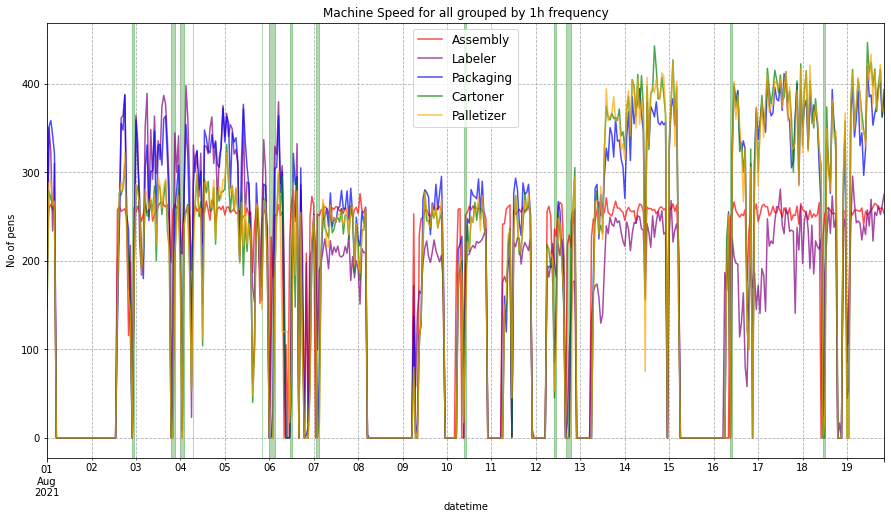

In [85]:
freq='1h'
group = df_speed.groupby(['Machine', pd.Grouper(freq=freq)]).mean().reset_index()
group.set_index('datetime', inplace=True)

# control the order of the machines so they match the line design
# machines = group.Machine.unique()
machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')
colors = ("red", "purple", "blue", "green", "orange")

i=0

fig, axs = plt.subplots(1, 1, figsize=(15, 8))

for x in machines:
    # group['IP_TREND_VALUE'][group.Machine == x].plot(color=colors[i], label=x, ax=axs, alpha=0.7)
    group['Derived_Speed'][group.Machine == x].plot(color=colors[i], label=x, ax=axs, alpha=0.7)
    # plt.yscale('log')
    axs.grid(True,which="both", linestyle='--')
    axs.set_title('Machine Speed for all grouped by {} frequency'.format(freq))
    axs.set_ylabel('No of pens')
    i+=1

    axs.legend()

for i, row in df_changeover3.iterrows():
    plt.axvspan(row[0], row[1], color='green', alpha=0.3)
    
mark_pdf.savefig(fig)

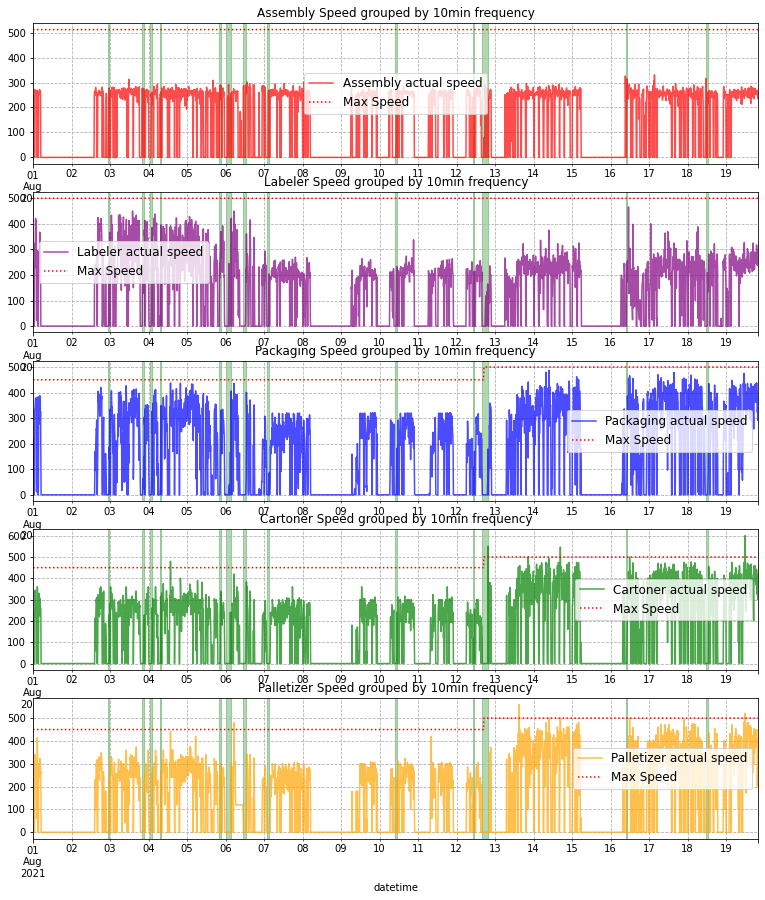

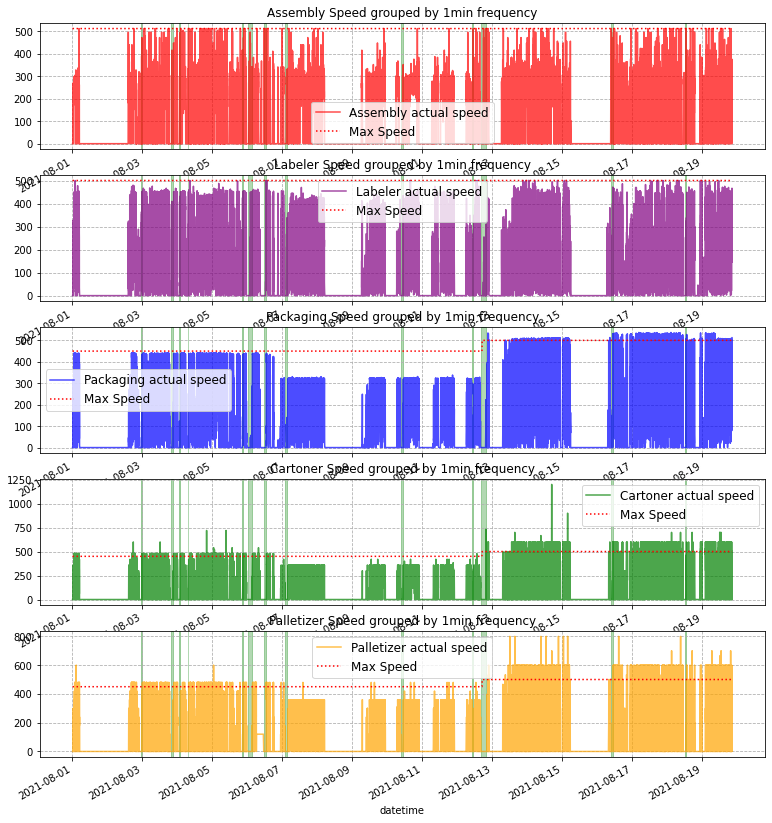

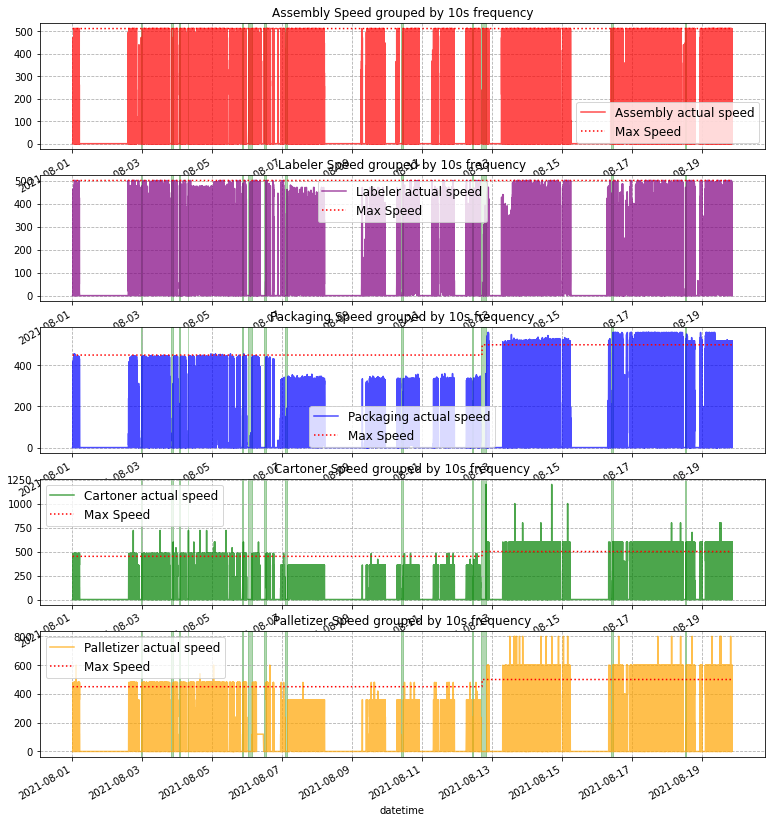

In [86]:
freq=('10min','1min','10s')

for f in freq:
    group = df_speed.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=f)]).mean().reset_index()
    group.set_index('datetime', inplace=True)

    # machines = group.Machine.unique()
    # control the order of the machines
    machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')


    fig, axs = plt.subplots(len(machines), 1, figsize=(13, 15))

    colors = ("red", "purple", "blue", "green", "orange")
    i=0

    for x in machines:
        group['Derived_Speed'][group.Machine == x].plot(color=colors[i], label=('{} actual speed'.format(x)), ax=axs[i], alpha=0.7)
        # plt.yscale('log')

        if max(group['Max_Speed'][group.Machine == x]) > 0:
            group['Max_Speed'][group.Machine == x].plot(color='red', ls=':', label='Max Speed', ax=axs[i])

        axs[i].grid(True,which="both", linestyle='--')
        axs[i].set_title('{} Speed grouped by {} frequency'.format(x, f))
        plt.rc('legend', fontsize=12)    # legend fontsize
        axs[i].legend()

        for c, row in df_changeover3.iterrows():
            axs[i].axvspan(row[0], row[1], color='green', alpha=0.3)

        i+=1
mark_pdf.savefig(fig)

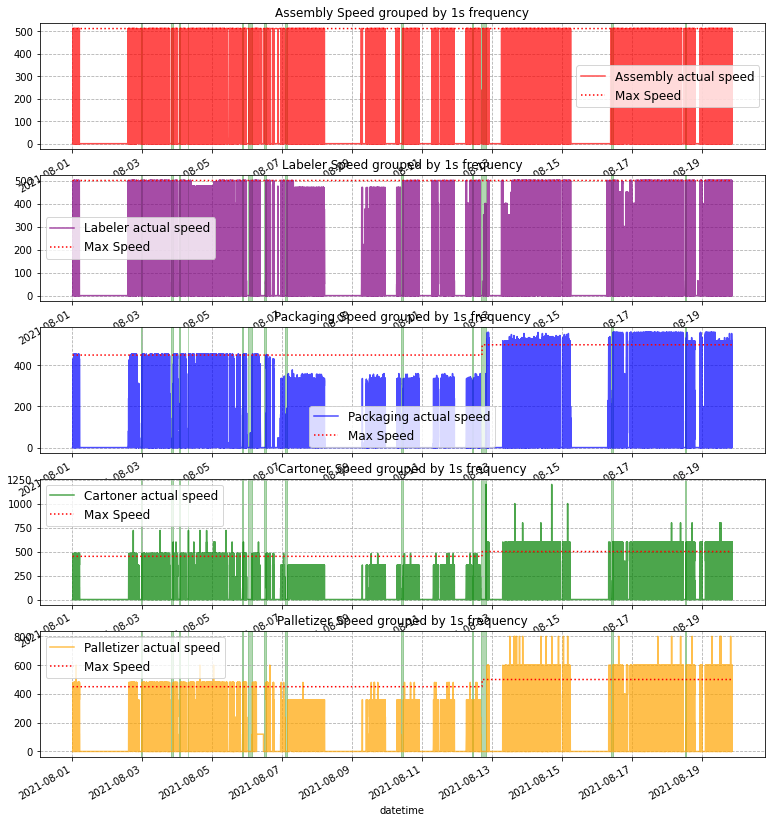

In [87]:
freq='1s'
group = df_speed.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=freq)]).mean().reset_index()
group.set_index('datetime', inplace=True)

# machines = group.Machine.unique()
# control the order of the machines
machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')


fig, axs = plt.subplots(len(machines), 1, figsize=(13, 15))

colors = ("red", "purple", "blue", "green", "orange")
i=0

for x in machines:
    group['Derived_Speed'][group.Machine == x].plot(color=colors[i], label=('{} actual speed'.format(x)), ax=axs[i], alpha=0.7)
    # plt.yscale('log')

    if max(group['Max_Speed'][group.Machine == x]) > 0:
        group['Max_Speed'][group.Machine == x].plot(color='red', ls=':', label='Max Speed', ax=axs[i])

    axs[i].grid(True,which="both", linestyle='--')
    axs[i].set_title('{} Speed grouped by {} frequency'.format(x, freq))
    plt.rc('legend', fontsize=12)    # legend fontsize
    axs[i].legend()
    
    for c, row in df_changeover3.iterrows():
        axs[i].axvspan(row[0], row[1], color='green', alpha=0.3)    

    i+=1

mark_pdf.savefig(fig)

In [22]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# max speed for each our
freq=['1h','30min','10min','1min', '1s']
print('\nPeriod: {} to {}'.format(start_date, end_date))

for f in freq:
    max_hours = df_speed.groupby([pd.Grouper(freq=f),'Machine'])['IP_TREND_VALUE'].agg(['mean','max']).unstack()
    max_hours.columns = [('mean',   'Assembly'),
            ('mean',    'Labeler'),
            ('mean',  'Packaging'),
            ('mean',   'Cartoner'),
            ('mean', 'Palletizer'),
            ( 'max',   'Assembly'),
            ( 'max',    'Labeler'),
            ( 'max',   'Cartoner'),
            ( 'max',  'Packaging'),
            ( 'max', 'Palletizer')]
    # print('\nMax Speeds by {}\n'.format(f), round(max_hours.describe(),2))

    print('\n{} period\n'.format(f), round(max_hours.agg(['mean','max']),2))
    
# f = '10min'
# df_speed.groupby([pd.Grouper(freq=f),'Machine'])['IP_TREND_VALUE'].agg(['mean','max']).unstack().reset_index()




Period: 2021-08-01 00:07:42.800000 to 2021-08-19 20:19:32.500000

1h period
          mean                                            max                                      
     Assembly Labeler Packaging Cartoner Palletizer Assembly Labeler Cartoner Packaging Palletizer
mean   175.77    1.24    165.89    53.10       1.24   360.55    2.31    345.4     82.72       2.28
max    279.73    2.76    397.79   129.27       2.68   512.00    6.00    500.0    152.00       5.00

30min period
          mean                                            max                                      
     Assembly Labeler Packaging Cartoner Palletizer Assembly Labeler Cartoner Packaging Palletizer
mean   161.01    1.13    153.39    48.19       1.13    328.4    2.01   316.57     74.44       1.99
max    292.00    2.88    414.77   144.00       2.96    512.0    6.00   500.00    152.00       5.00

10min period
          mean                                            max                                      
 


Period: 2021-08-01 00:07:42.800000 to 2021-08-19 20:19:32.500000


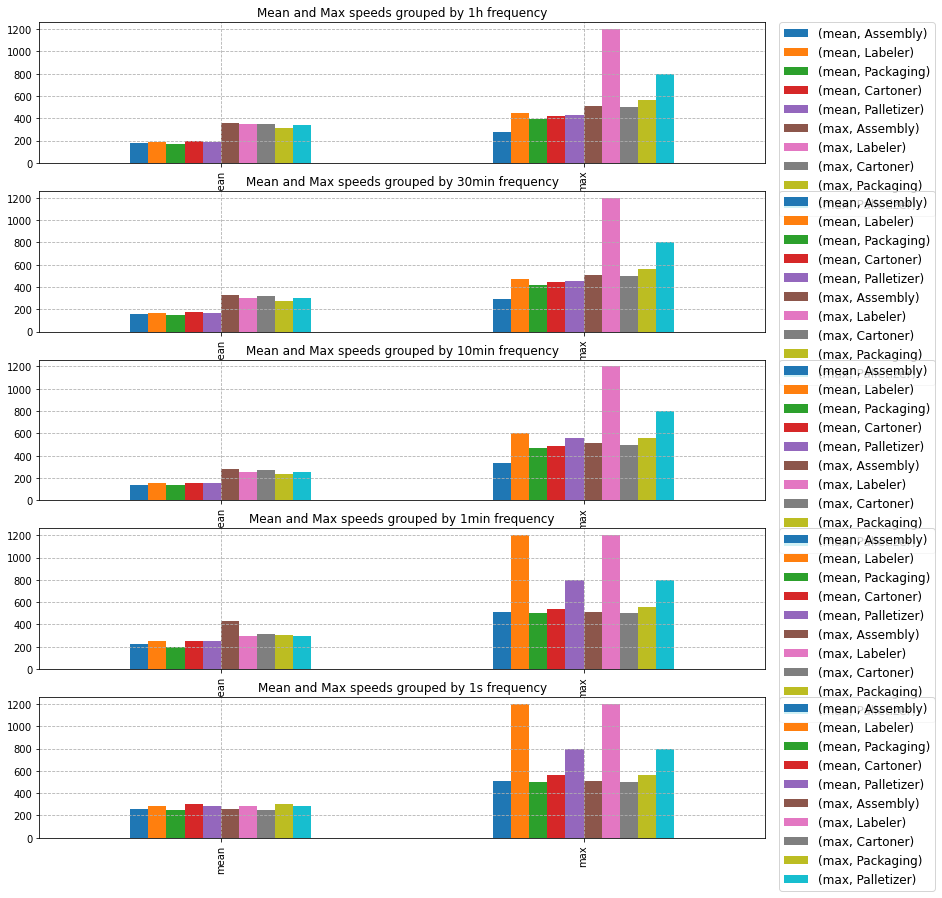

In [23]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# max speed for each our
freq=['1h','30min','10min','1min', '1s']
print('\nPeriod: {} to {}'.format(start_date, end_date))

fig, axs = plt.subplots(len(freq), 1, figsize=(13, 15))

colors = ("red", "purple", "blue", "green", "orange")
i=0

for f in freq:
    max_hours = df_speed.groupby([pd.Grouper(freq=f),'Machine'])['Derived_Speed'].agg(['mean','max']).unstack()
    max_hours.columns = [('mean',   'Assembly'),
            ('mean',    'Labeler'),
            ('mean',  'Packaging'),
            ('mean',   'Cartoner'),
            ('mean', 'Palletizer'),
            ( 'max',   'Assembly'),
            ( 'max',    'Labeler'),
            ( 'max',   'Cartoner'),
            ( 'max',  'Packaging'),
            ( 'max', 'Palletizer')]

    max_hours.agg({'mean','max'}).sort_index(ascending=False).plot.bar(ax=axs[i])

    # plt.yscale('log')

    axs[i].grid(True,which="both", linestyle='--')
    axs[i].set_title('Mean and Max speeds grouped by {} frequency'.format(f))
    plt.rc('legend', fontsize=12)    # legend fontsize
    #place legend outside top right corner of plot
#     handles, labels = axs[i].get_legend_handles_labels()
#     axs[i].legend(handles, labels)
    axs[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    i+=1

# f = '10min'
# df_speed.groupby([pd.Grouper(freq=f),'Machine'])['IP_TREND_VALUE'].agg(['mean','max']).unstack().reset_index()



In [24]:
max_hours = df_speed.groupby([pd.Grouper(freq='1s'),'Machine'])['Derived_Speed'].agg(['mean','max']).unstack()

In [25]:
max_hours.agg({'mean','max'})

mean                                                          max                                                 
        Assembly     Cartoner     Labeler   Packaging  Palletizer    Assembly     Cartoner     Labeler   Packaging  Palletizer
mean  254.900697   285.371287  253.005197  306.683199  284.113866  255.291099   285.378713  253.149309  306.683772  284.113866
max   512.000000  1200.000000  500.000000  560.000000  800.000000  512.000000  1200.000000  500.000000  560.000000  800.000000

In [26]:
max_hours.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276188 entries, 2021-08-01 00:07:42 to 2021-08-19 20:19:31
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   (mean, Assembly)    101024 non-null  float64
 1   (mean, Cartoner)    16160 non-null   float64
 2   (mean, Labeler)     90718 non-null   float64
 3   (mean, Packaging)   96930 non-null   float64
 4   (mean, Palletizer)  16335 non-null   float64
 5   (max, Assembly)     101024 non-null  float64
 6   (max, Cartoner)     16160 non-null   float64
 7   (max, Labeler)      90718 non-null   float64
 8   (max, Packaging)    96930 non-null   float64
 9   (max, Palletizer)   16335 non-null   float64
dtypes: float64(10)
memory usage: 23.2 MB


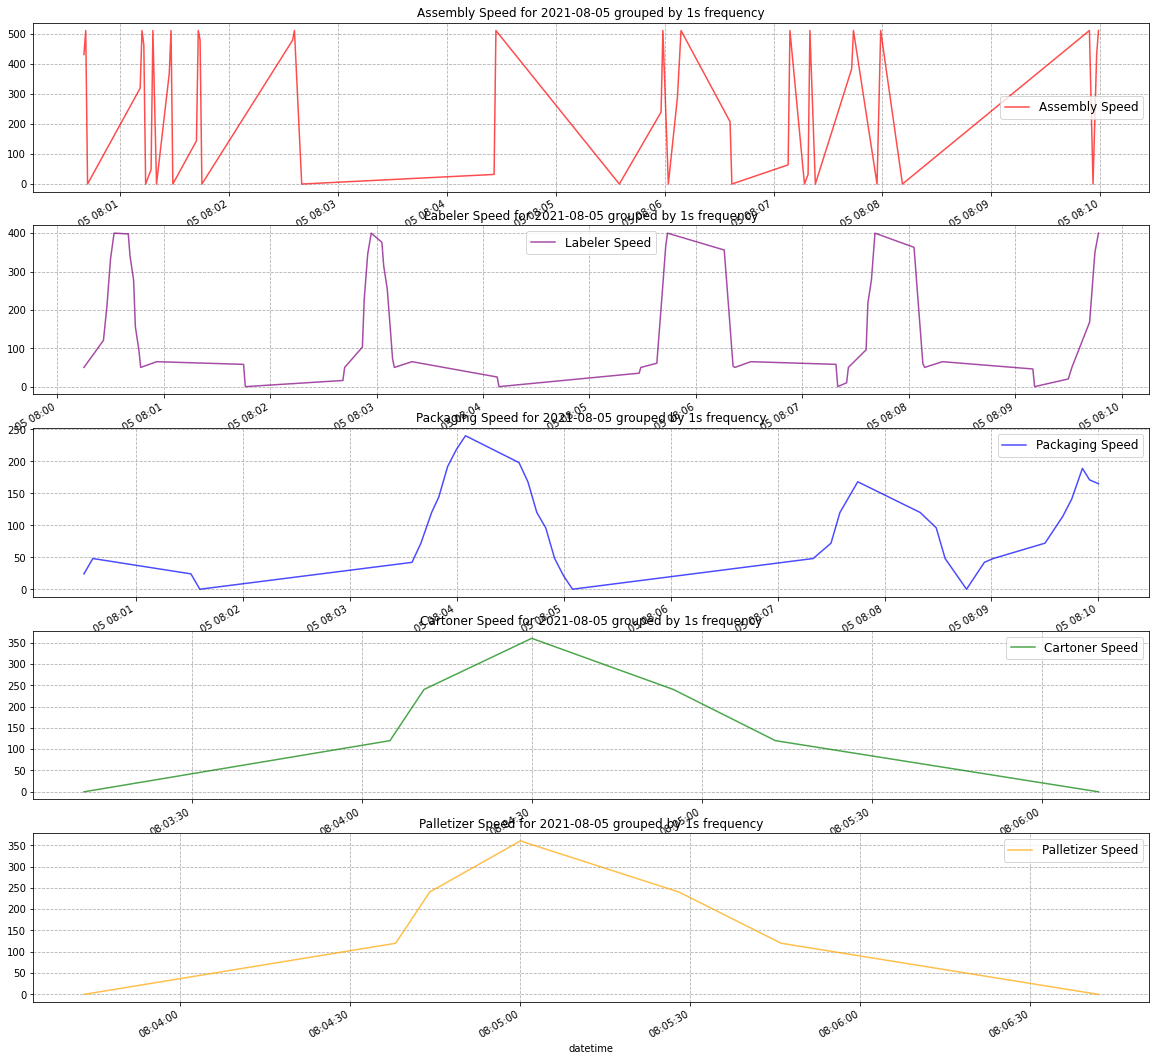

In [27]:
daterange = '2021-08-05'
times = ['08:00', '08:10']
freq='1s'

dates = group.loc[daterange]
dates = dates.between_time(times[0], times[1])

dates = dates.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=freq)]).mean().reset_index()
dates.set_index('datetime', inplace=True)


fig, axs = plt.subplots(len(machines), 1, figsize=(20, 20))

colors = ("red", "purple", "blue", "green", "orange")
i=0

for x in machines:
    dates['Derived_Speed'][dates.Machine == x].plot(color=colors[i], label=('{} Speed'.format(x)), ax=axs[i], alpha=0.7)
    # plt.yscale('log')

    axs[i].grid(True,which="both", linestyle='--')
    axs[i].set_title('{} Speed for {} grouped by {} frequency'.format(x, daterange, freq))
    plt.rc('legend', fontsize=12)    # legend fontsize
    axs[i].legend()
    i+=1

In [28]:
df_speed.groupby(['Machine', 'Max_Speed', pd.Grouper(freq='1min')]).Derived_Speed.mean().reset_index()
# df_speed[df_speed == x].Derived_Speed

,Machine,Max_Speed,datetime,Derived_Speed
0,Assembly,512.0,2021-08-01 00:08:00,0.000000
1,Assembly,512.0,2021-08-01 00:18:00,0.000000
2,Assembly,512.0,2021-08-01 00:28:00,152.000000
3,Assembly,512.0,2021-08-01 00:29:00,232.000000
4,Assembly,512.0,2021-08-01 00:30:00,270.222222
...,...,...,...,...
57051,Palletizer,500.0,2021-08-19 20:12:00,400.000000
57052,Palletizer,500.0,2021-08-19 20:13:00,500.000000
57053,Palletizer,500.0,2021-08-19 20:14:00,400.000000
57054,Palletizer,500.0,2021-08-19 20:16:00,200.000000


ValueError: color kwarg must have one color per data set. 27132 data sets and 1 colors were provided

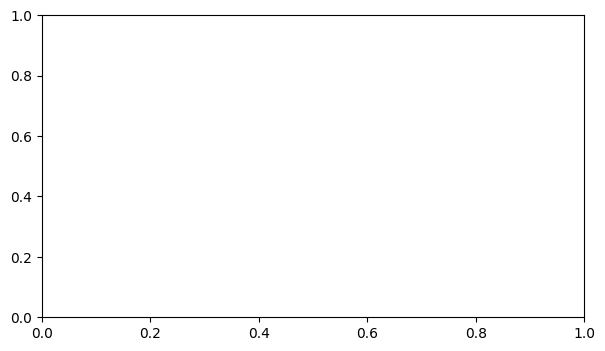

In [66]:
plt.subplots(figsize=(7,4), dpi=100)

freq='1min'

i=0
for x in machines:

    # data = df_speed[df_speed == x].Derived_Speed.sort_values(ascending=False)
    data = df_speed[df_speed.Machine == x].groupby([pd.Grouper(freq=freq)]).Derived_Speed.mean().reset_index()
    data.set_index('datetime', inplace=True)
    kwargs = dict(histtype='stepfilled', label=x, alpha=0.3, bins=40, color=colors[i])
    plt.hist(data, **kwargs)
    plt.legend()
    # plt.yscale('log')
    i+=1

plt.title('Speed Histogram by {} periods'.format(freq))
# plt.ylabel('{} count'.format(freq))
plt.xlabel('Speed')

plt.subplots(figsize=(7,4), dpi=100)
i=0
for x in machines:

    data = df_speed[df_speed.Machine == x].groupby([pd.Grouper(freq=freq)]).Derived_Speed.mean().reset_index()
    data.set_index('datetime', inplace=True)
    # data = df_speed.loc[df_speed.Machine == x, 'Derived_Speed'].sort_values(ascending=False)
    sns.distplot (data, color=colors[i], label=x, kde=False)
    i+=1

plt.title('Speed Histogram by {} periods'.format(freq))
plt.legend();


In [30]:
# drop data between 22:00 on Sat through to 06:00 on Monday, as Sunday is closed on AL6
# get Tues - fri data first
df_speed_no_sunday = df_speed[(df_speed.index.dayofweek > 0) & (df_speed.index.dayofweek < 5)]

# get Mon between 06:00 and 23:59
df_mon = df_speed[df_speed.index.dayofweek == 0]
df_mon = df_mon.between_time('06:00', '23:59')
df_speed_no_sunday = df_speed_no_sunday.append(df_mon)

# get saturday between 00:00 and 22:00
df_sat = df_speed[df_speed.index.dayofweek == 5]
df_sat = df_sat.between_time('00:00', '22:00')
df_speed_no_sunday = df_speed_no_sunday.append(df_sat)

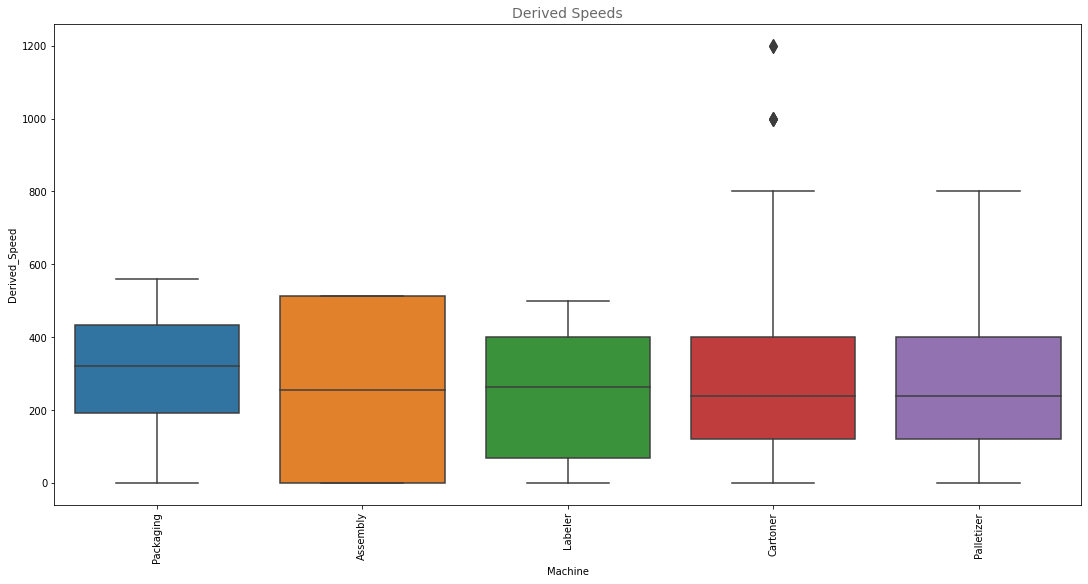

In [88]:
# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(15, 8))

sns.boxplot(x='Machine', y='Derived_Speed', data=df_speed, whis=1.5, fliersize=10).set_title('Derived Speeds', color='dimgrey', size=14)
plt.xticks(rotation=90)

mark_pdf.savefig(fig)

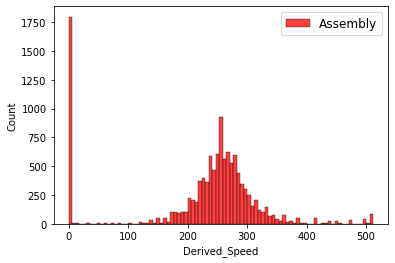

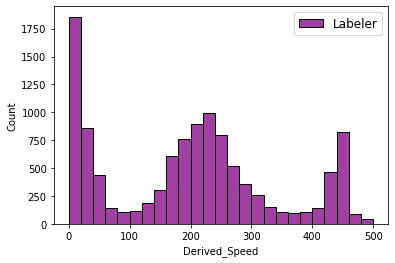

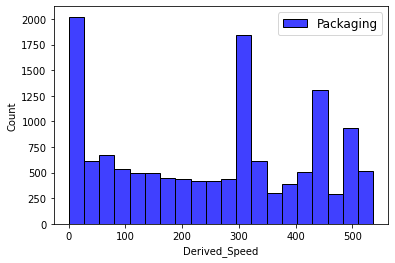

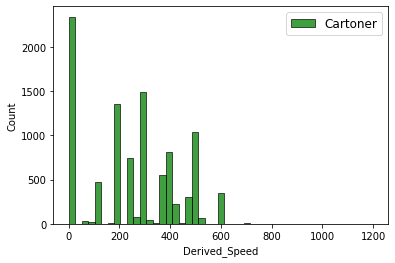

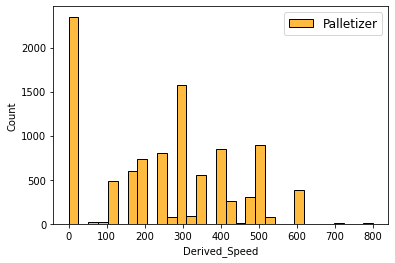

In [89]:
data = df_speed.groupby(['Machine', pd.Grouper(freq='1min')]).Derived_Speed.mean().reset_index()
data.set_index('datetime', inplace=True)

i=0
for x in machines:
    sns.histplot(data[data.Machine == x].Derived_Speed, kde=False, color=colors[i], label=x)
    plt.legend()
    plt.show()
    i+=1
    
    mark_pdf.savefig(fig)

In [57]:
data.loc[data.Machine == 'Assembly'].groupby('Derived_Speed').count().sort_values('Machine', ascending=False)

,Machine
Derived_Speed,
0.000000,1797
256.000000,469
240.000000,236
277.333333,180
218.666667,140
...,...
270.608696,1
230.285714,1
230.095238,1


In [90]:
mark_pdf.close()